# Machine Learning

Este trabajo va a consistir en la limpieza y análisis de unos datos dados, para posteriormente proceder a analizar el agrupamiento de los datos y encontrar el mejor a través de diferentes técnicas.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from scipy import linalg
import itertools
import matplotlib as mpl

from scipy.cluster.hierarchy import linkage, fcluster

### 1. PREPROCESSING

Lo primero que haremos en esta fase será leer el documento, además creamos una copia de seguridad antes de empezar con el proceso del tratamiento de los datos, este paos es importante para poder retomar el caso desde el principio en caso de que encontremos porblemas a lo largo del trabajo.

Además empezaremos haciendo un estudio de los datos que tenemos en el csv para ver que deberíamos limpiar en primer lugar.

--------- ANÁLISIS DATOS

In [49]:
data_or = pd.read_csv("data-even.csv")
data = data_or.copy()

#Observamos las columnas de nuestro csv
print(data.head()) 

   Age   Education  EducationNum        MaritalStatus    Relationship Gender  \
0   39   Bachelors            13        Never-married   Not-in-family   Male   
1   50   Bachelors            13   Married-civ-spouse         Husband   Male   
2   52     HS-grad             9   Married-civ-spouse         Husband   Male   
3   30   Bachelors            13   Married-civ-spouse         Husband   Male   
4   25     HS-grad             9        Never-married       Own-child   Male   

   CapitalGain  HoursPerWeek  
0         2174            40  
1            0            13  
2            0            45  
3            0            40  
4            0            35  


Una vez leidos los datos, procedemos a realizar un estudio básica de las variables que nos encontramos.

In [50]:
print("Shape:", data.shape)
print("\nColumnas:")
print(data.columns.tolist())

print("\nInfo:")
print(data.info())

Shape: (9865, 8)

Columnas:
['Age', 'Education', 'EducationNum', 'MaritalStatus', 'Relationship', 'Gender', 'CapitalGain', 'HoursPerWeek']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9865 entries, 0 to 9864
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            9865 non-null   int64 
 1   Education      9865 non-null   object
 2   EducationNum   9865 non-null   int64 
 3   MaritalStatus  9865 non-null   object
 4   Relationship   9865 non-null   object
 5   Gender         9865 non-null   object
 6   CapitalGain    9865 non-null   int64 
 7   HoursPerWeek   9865 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 616.7+ KB
None


Como vemos tenemos datos de diferentes tipos tenemos tanto del tipo obj como del tipo enteros, por lo tanto a la hora de limpiar tendremos que buscar una solución para ello.

Ahora buscamos el número de filas con missing data, esto son tanto valores con Null o Nan o sinplemente que no haya escrito nada.

In [51]:
#Revisar valores faltantes por columna
missing_data_count = data.isnull().sum()
print("Número de filas con datos faltantes por columna:")
print(missing_data_count)

#Contar filas con al menos un valor faltante
total_missing_rows = data.isnull().any(axis=1).sum()
print("\nNúmero total de filas con datos faltantes:", total_missing_rows)

Número de filas con datos faltantes por columna:
Age              0
Education        0
EducationNum     0
MaritalStatus    0
Relationship     0
Gender           0
CapitalGain      0
HoursPerWeek     0
dtype: int64

Número total de filas con datos faltantes: 0


In [52]:
empty_strings_count = (data == "").sum()
print("Número de celdas vacías ('') por columna:")
print(empty_strings_count)


Número de celdas vacías ('') por columna:
Age              0
Education        0
EducationNum     0
MaritalStatus    0
Relationship     0
Gender           0
CapitalGain      0
HoursPerWeek     0
dtype: int64


Por suerte, no nos encontramos con valores faltantes lo que simplifica mucho la limpieza, ya que no tendremos que plantearnos que método usar para rellenar o reemplazar esos espacios.

Filas duplicadas

*En este caso se nos pueden presentar muchas filas que digan que son duplicadas, pero pueden ser personas diferentes que han coincidido que tienen los mismos datos.*

De todas maneras eliminaremos los duplicados ya que la eliminación de filas duplicadas en el dataset no altera los resultados del clustering jerárquico ni la estructura del dendrograma, ya que los duplicados representan observaciones idénticas en todas las variables y, por lo tanto, no aportan información adicional sobre las distancias entre los puntos.

In [53]:
duplicate_rows = data[data.duplicated()]
print("Número de filas duplicadas:", len(duplicate_rows))

# Mostrar duplicados si existen
duplicate_mask = data.duplicated(keep=False)  # keep=False marca todas las ocurrencias
display(data[duplicate_mask].sort_values(list(data.columns)))

Número de filas duplicadas: 2810


Age     Education  EducationNum        MaritalStatus Relationship  \
1544   17          10th             6        Never-married    Own-child   
9625   17          10th             6        Never-married    Own-child   
545    17          10th             6        Never-married    Own-child   
5079   17          10th             6        Never-married    Own-child   
7525   17          10th             6        Never-married    Own-child   
...   ...           ...           ...                  ...          ...   
7299   79       HS-grad             9   Married-civ-spouse      Husband   
5623   80       HS-grad             9   Married-civ-spouse      Husband   
6400   80       HS-grad             9   Married-civ-spouse      Husband   
358    88   Prof-school            15   Married-civ-spouse      Husband   
6669   88   Prof-school            15   Married-civ-spouse      Husband   

       Gender  CapitalGain  HoursPerWeek  
1544   Female            0            15  
9625   Female            0            15  
545    Female            0            20  
5079   Female            0            20  
7525   Female            0            20  
...       ...          ...           ...  
7299     Male            0            40  
5623     Male            0             8  
6400     Male            0             8  
358      Male            0            40  
6669     Male            0            40  

[3953 rows x 8 columns]

Buscamos valores atípicos.

Vamos a mirar los valores atípicos antes de la limpieza para observar los ragos naturales del dataset pero también lo realizaremos una vez hayamos completado todas las transformaciones y lo hayamos escalado.

In [54]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=np.number)

numerical_stats = numerical_data.describe()

Q1 = numerical_stats.loc['25%']
Q3 = numerical_stats.loc['75%']
IQR = Q3 - Q1
numerical_stats.loc['IQR'] = IQR

numerical_stats

Age  EducationNum   CapitalGain  HoursPerWeek
count  9865.000000   9865.000000   9865.000000   9865.000000
mean     42.686163     10.543031   1511.164420     40.829397
std      14.539611      2.685759   9209.395181     14.543395
min      17.000000      1.000000      0.000000      1.000000
25%      32.000000      9.000000      0.000000     38.000000
50%      42.000000     10.000000      0.000000     40.000000
75%      53.000000     13.000000      0.000000     48.000000
max      90.000000     16.000000  99999.000000     99.000000
IQR      21.000000      4.000000      0.000000     10.000000

Observaciones:

*Age:* rango de 17 a 90 años, media ~42.7.

*CapitalGain:* muy sesgada, con muchos ceros y valores extremos hasta 99,999.

*HoursPerWeek:* la mayoría alrededor de 40 horas.

Ahora veremos un estudio gráfico a través de histogramas y boxplots individuales.


Columnas numéricas detectadas: ['Age', 'EducationNum', 'CapitalGain', 'HoursPerWeek']


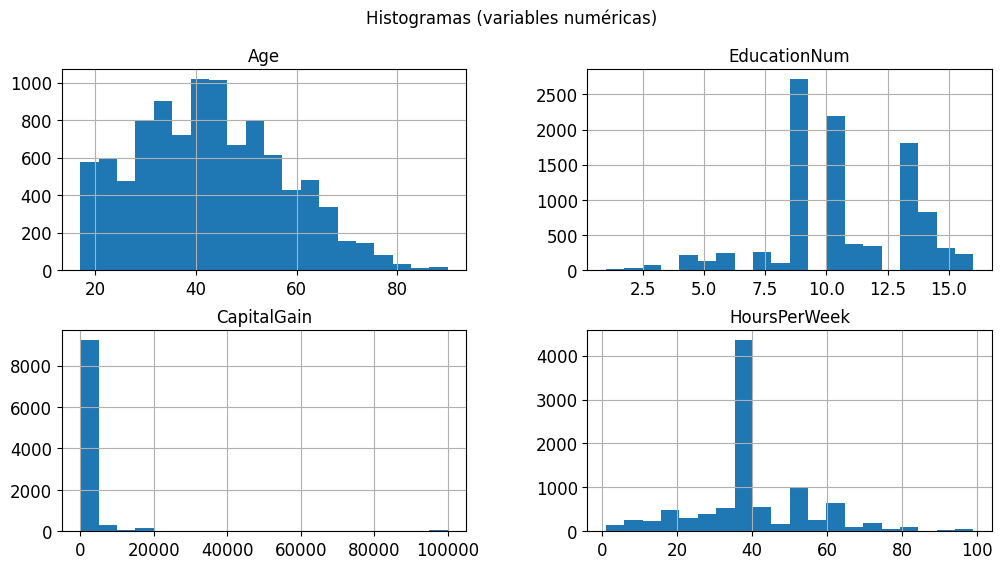

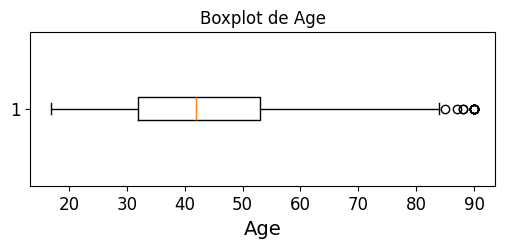

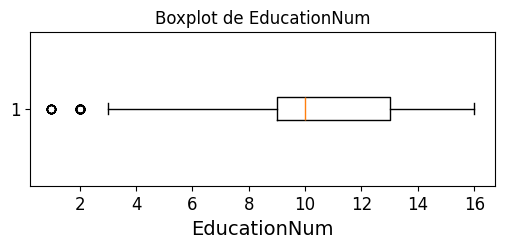

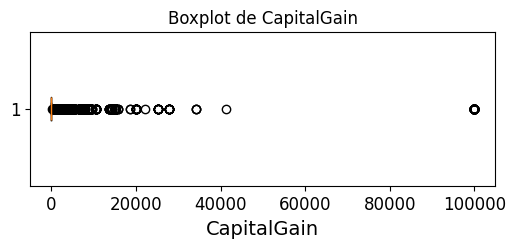

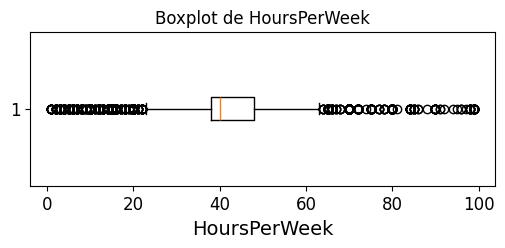

In [55]:
num_cols = data.select_dtypes(include=['int64']).columns.tolist()
print("\nColumnas numéricas detectadas:", num_cols)

if len(num_cols) > 0:
    # Histogramas
    data[num_cols].hist(bins=20, figsize=(12,6))
    plt.suptitle("Histogramas (variables numéricas)")
    plt.show()

    # Boxplots individuales
    for c in num_cols:
        plt.figure(figsize=(6,2))
        plt.boxplot(data[c].dropna(), vert=False) 
        plt.title(f"Boxplot de {c}")
        plt.xlabel(c)
        plt.show()



Observaciones:

*CapitalGain* tiene muchos valores extremos (outliers).

*Age y HoursPerWeek* están relativamente distribuidos de forma normal.

*EducationNum* tiene pocos valores únicos, consistente con su carácter ordinal, ya que refleja niveles educativos con un orden natural.

Por último realizaremos un estudio de la correlación entre variables numéricas, para poder detectar si hay redundancia entre las variables.

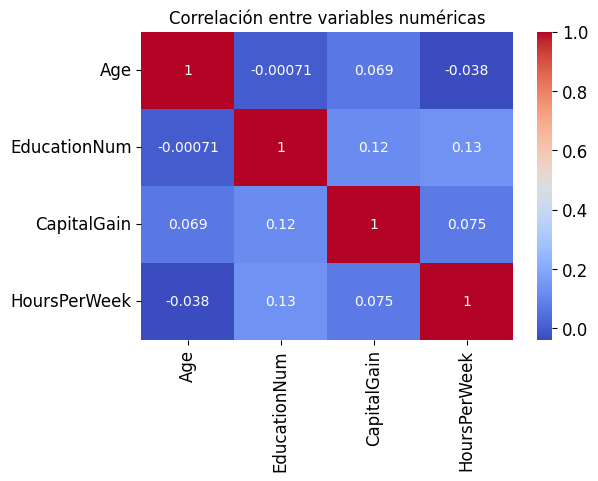

In [56]:
plt.figure(figsize=(6,4))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()

Todos los valores presentan una correlación bastante débil, asi que consideramos que todas las variables numéricas presentadas tienen su importancia y no eliminaremos ninguna de momento.

----------- LIMPIEZA DATOS

Una vez realizado el análisis de los datos procedemos ha hacer una primera limpieza, aunque debemos tener en cuenta que más tarde puede que tengamos que volver a esta parte para agustarla a los criterios que nos vayamos encontrando.

En primer lugar realizamos una limpieza mínima de nombres de columnas (espacios, mayúsculas inconsistentes).

In [57]:
data.columns = data.columns.str.strip()       # quita espacios al inicio/fin
data.columns = data.columns.str.replace(' ', '')  # quita espacios internos

Además podrimos estudiar si hay columnas en la tabla que son redundantes, por ejemplo, Education y EducationNum, en este caso nos quedariamos con la segunda columna ya que se encuentra en valores numéricos.

In [58]:
data = data.drop(columns=['Education'])

Aplicamos OneHotEncoding para pasar la columna gender a una varibale numérica que nos permita hacer clustering.

In [59]:
ohe = OneHotEncoder(drop='first', sparse_output=False) 

encoded_gender = ohe.fit_transform(data[['Gender']])

encoded_gender_df = pd.DataFrame(encoded_gender, columns=ohe.get_feature_names_out(['Gender']))

data = data.drop(columns=['Gender'])
data = pd.concat([data, encoded_gender_df], axis=1)

print(encoded_gender_df.head())


   Gender_ Male
0           1.0
1           1.0
2           1.0
3           1.0
4           1.0


Ahora estudiaremos las otras dos variables que no son numéricas, pero primeor al ser estas mas complejas vamos a ver cuantas posibilidades diferentes hay en cada columna.

In [60]:
categorical_cols = ['MaritalStatus', 'Relationship']

for col in categorical_cols:
    print(f"{col}: {data[col].nunique()} categorías")
    print(data[col].unique())
    print()

MaritalStatus: 7 categorías
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Widowed' ' Married-AF-spouse']

Relationship: 6 categorías
[' Not-in-family' ' Husband' ' Own-child' ' Unmarried' ' Wife'
 ' Other-relative']



Para las variables categóricas MaritalStatus y Relationship, se optó nuevamente por utilizar One-Hot Encoding en lugar de una codificación personalizada o el uso de OrdinalEncoder. Esta decisión se fundamenta en que ambas variables son nominales, es decir, no poseen un orden natural entre sus categorías. One-Hot Encoding permite transformar cada categoría en una columna binaria independiente, preservando la independencia entre categorías y evitando que el algoritmo de clustering interprete un orden o distancia artificial.

In [61]:
cat_cols = ['MaritalStatus', 'Relationship']

data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(float)

Una vez que todos los datos se han convertido a valores numéricos, podemos eliminar los duplicados, ya que no aportan información nueva al análisis. Esta limpieza reduce redundancia y optimiza el cálculo del clustering sin afectar la estructura ni los resultados del análisis jerárquico.

In [62]:
print("Tamaño del dataset antes de drop_duplicates:", data.shape)
data = data.drop_duplicates()
print("Tamaño después de drop_duplicates:", data.shape)

Tamaño del dataset antes de drop_duplicates: (9865, 16)
Tamaño después de drop_duplicates: (7055, 16)


En este caso de estudio Capitalgain tiene valores muy extremos y muchos ceros → distribución muy sesgada.

El log reduce el efecto de los valores extremos y hace que la variable sea más homogénea, evitando que domine el clustering. Como presentaba una gran concentración de valores en cero y algunos valores extremadamente altos, 
para reducir esta asimetría y evitar que los valores extremos dominen el análisis, se aplicó la transformación logarítmica que permite manejar ceros de forma segura.

In [63]:
data['CapitalGain_log'] = np.log1p(data['CapitalGain'])
data = data.drop(columns=['CapitalGain'])
data_cleaned = data

Escalar las variables

En clustering, como se calculan distancias entre puntos, si una variable tiene un rango mucho mayor que otra, dominará la distancia y distorsionará los resultados. Escalar las variables a media 0 y desviación estándar 1 iguala su escala, asegurando que todas contribuyan de manera equilibrada al clustering.

In [64]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

In [65]:
print(data.std())

Age                                     1.000071
EducationNum                            1.000071
HoursPerWeek                            1.000071
Gender_ Male                            1.000071
MaritalStatus_ Married-AF-spouse        1.000071
MaritalStatus_ Married-civ-spouse       1.000071
MaritalStatus_ Married-spouse-absent    1.000071
MaritalStatus_ Never-married            1.000071
MaritalStatus_ Separated                1.000071
MaritalStatus_ Widowed                  1.000071
Relationship_ Not-in-family             1.000071
Relationship_ Other-relative            1.000071
Relationship_ Own-child                 1.000071
Relationship_ Unmarried                 1.000071
Relationship_ Wife                      1.000071
CapitalGain_log                         1.000071
dtype: float64


Visualizamos el resultado final una vez hemos realizado la limpieza.

In [66]:
print(data.dtypes)
print(data.head())

Age                                     float64
EducationNum                            float64
HoursPerWeek                            float64
Gender_ Male                            float64
MaritalStatus_ Married-AF-spouse        float64
MaritalStatus_ Married-civ-spouse       float64
MaritalStatus_ Married-spouse-absent    float64
MaritalStatus_ Never-married            float64
MaritalStatus_ Separated                float64
MaritalStatus_ Widowed                  float64
Relationship_ Not-in-family             float64
Relationship_ Other-relative            float64
Relationship_ Own-child                 float64
Relationship_ Unmarried                 float64
Relationship_ Wife                      float64
CapitalGain_log                         float64
dtype: object
        Age  EducationNum  HoursPerWeek  Gender_ Male  \
0 -0.315390      0.852018     -0.032797      0.743598   
1  0.417924      0.852018     -1.694790      0.743598   
2  0.551254     -0.537645      0.274979      0.

In [67]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['int64', 'float64', 'bool'])

numerical_stats = numerical_data.describe()

Q1 = numerical_stats.loc['25%']
Q3 = numerical_stats.loc['75%']
IQR = Q3 - Q1
numerical_stats.loc['IQR'] = IQR

numerical_stats

Age  EducationNum  HoursPerWeek  Gender_ Male  \
count  7.055000e+03  7.055000e+03  7.055000e+03  7.055000e+03   
mean  -8.862900e-17  1.258935e-16  1.732294e-16 -1.248863e-16   
std    1.000071e+00  1.000071e+00  1.000071e+00  1.000071e+00   
min   -1.782017e+00 -3.316972e+00 -2.433454e+00 -1.344812e+00   
25%   -7.820439e-01 -5.376451e-01 -3.405740e-01 -1.344812e+00   
50%   -4.873010e-02 -1.902292e-01 -3.279750e-02  7.435984e-01   
75%    6.845837e-01  8.520182e-01  5.827555e-01  7.435984e-01   
max    3.084520e+00  1.894266e+00  3.598965e+00  7.435984e-01   
IQR    1.466628e+00  1.389663e+00  9.233294e-01  2.088410e+00   

       MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
count                      7.055000e+03                       7.055000e+03   
mean                       3.348766e-17                      -4.129306e-17   
std                        1.000071e+00                       1.000071e+00   
min                       -3.369325e-02                      -9.457633e-01   
25%                       -3.369325e-02                      -9.457633e-01   
50%                       -3.369325e-02                      -9.457633e-01   
75%                       -3.369325e-02                       1.057347e+00   
max                        2.967954e+01                       1.057347e+00   
IQR                        0.000000e+00                       2.003110e+00   

       MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
count                          7.055000e+03                  7.055000e+03   
mean                          -8.057182e-18                 -4.834309e-17   
std                            1.000071e+00                  1.000071e+00   
min                           -1.292946e-01                 -5.861345e-01   
25%                           -1.292946e-01                 -5.861345e-01   
50%                           -1.292946e-01                 -5.861345e-01   
75%                           -1.292946e-01                  1.706093e+00   
max                            7.734272e+00                  1.706093e+00   
IQR                            0.000000e+00                  2.292228e+00   

       MaritalStatus_ Separated  MaritalStatus_ Widowed  \
count              7.055000e+03            7.055000e+03   
mean               5.942172e-17           -3.625732e-17   
std                1.000071e+00            1.000071e+00   
min               -1.987140e-01           -2.432083e-01   
25%               -1.987140e-01           -2.432083e-01   
50%               -1.987140e-01           -2.432083e-01   
75%               -1.987140e-01           -2.432083e-01   
max                5.032358e+00            4.111702e+00   
IQR                0.000000e+00            0.000000e+00   

       Relationship_ Not-in-family  Relationship_ Other-relative  \
count                 7.055000e+03                  7.055000e+03   
mean                 -4.330735e-17                 -6.042886e-18   
std                   1.000071e+00                  1.000071e+00   
min                  -6.165112e-01                 -1.708092e-01   
25%                  -6.165112e-01                 -1.708092e-01   
50%                  -6.165112e-01                 -1.708092e-01   
75%                   1.622031e+00                 -1.708092e-01   
max                   1.622031e+00                  5.854485e+00   
IQR                   2.238542e+00                  0.000000e+00   

       Relationship_ Own-child  Relationship_ Unmarried  Relationship_ Wife  \
count             7.055000e+03             7.055000e+03        7.055000e+03   
mean              1.107863e-16            -4.733594e-17       -6.244316e-17   
std               1.000071e+00             1.000071e+00        1.000071e+00   
min              -3.553549e-01            -3.686298e-01       -2.785548e-01   
25%              -3.553549e-01            -3.686298e-01       -2.785548e-01   
50%              -3.553549e-01            -3.686298e-01       -2.78

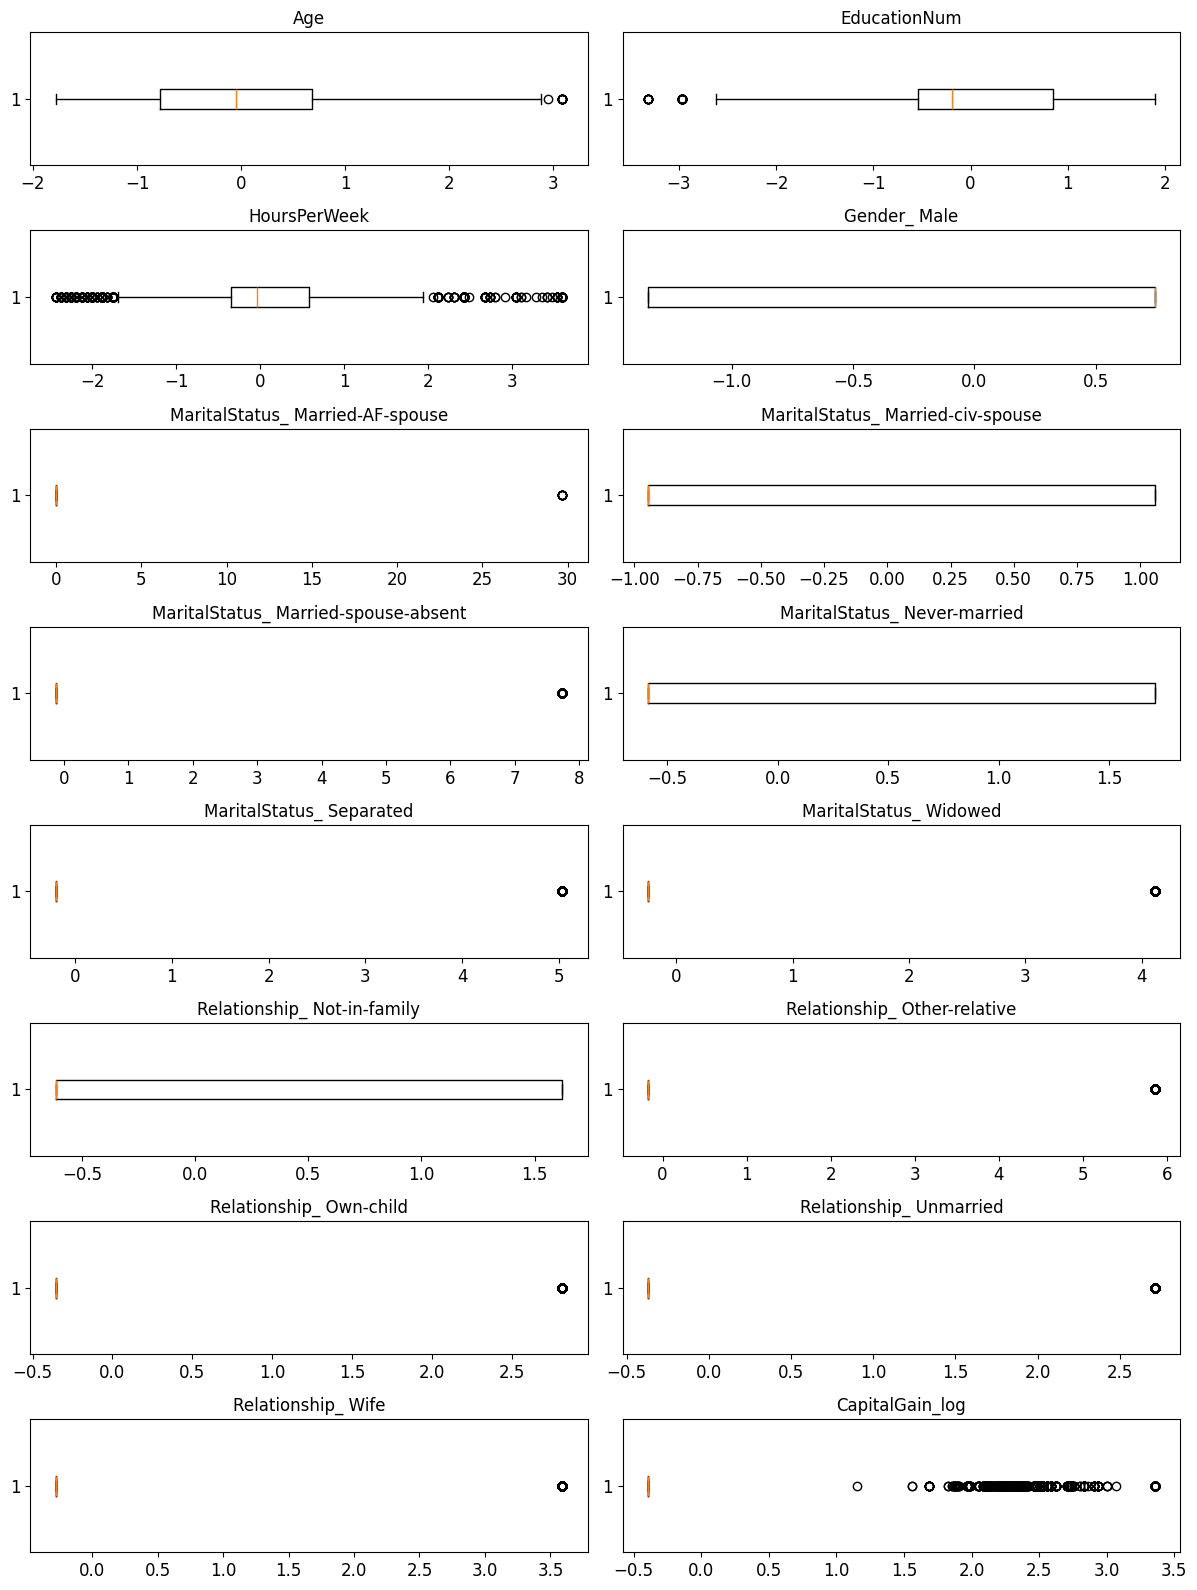

In [ ]:
import math

num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
n = len(num_cols)
cols = 2  # número de columnas en la figura
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows*2))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    ax.boxplot(data[col].dropna(), vert=False)
    ax.set_title(col)

# Ocultar ejes sobrantes
for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



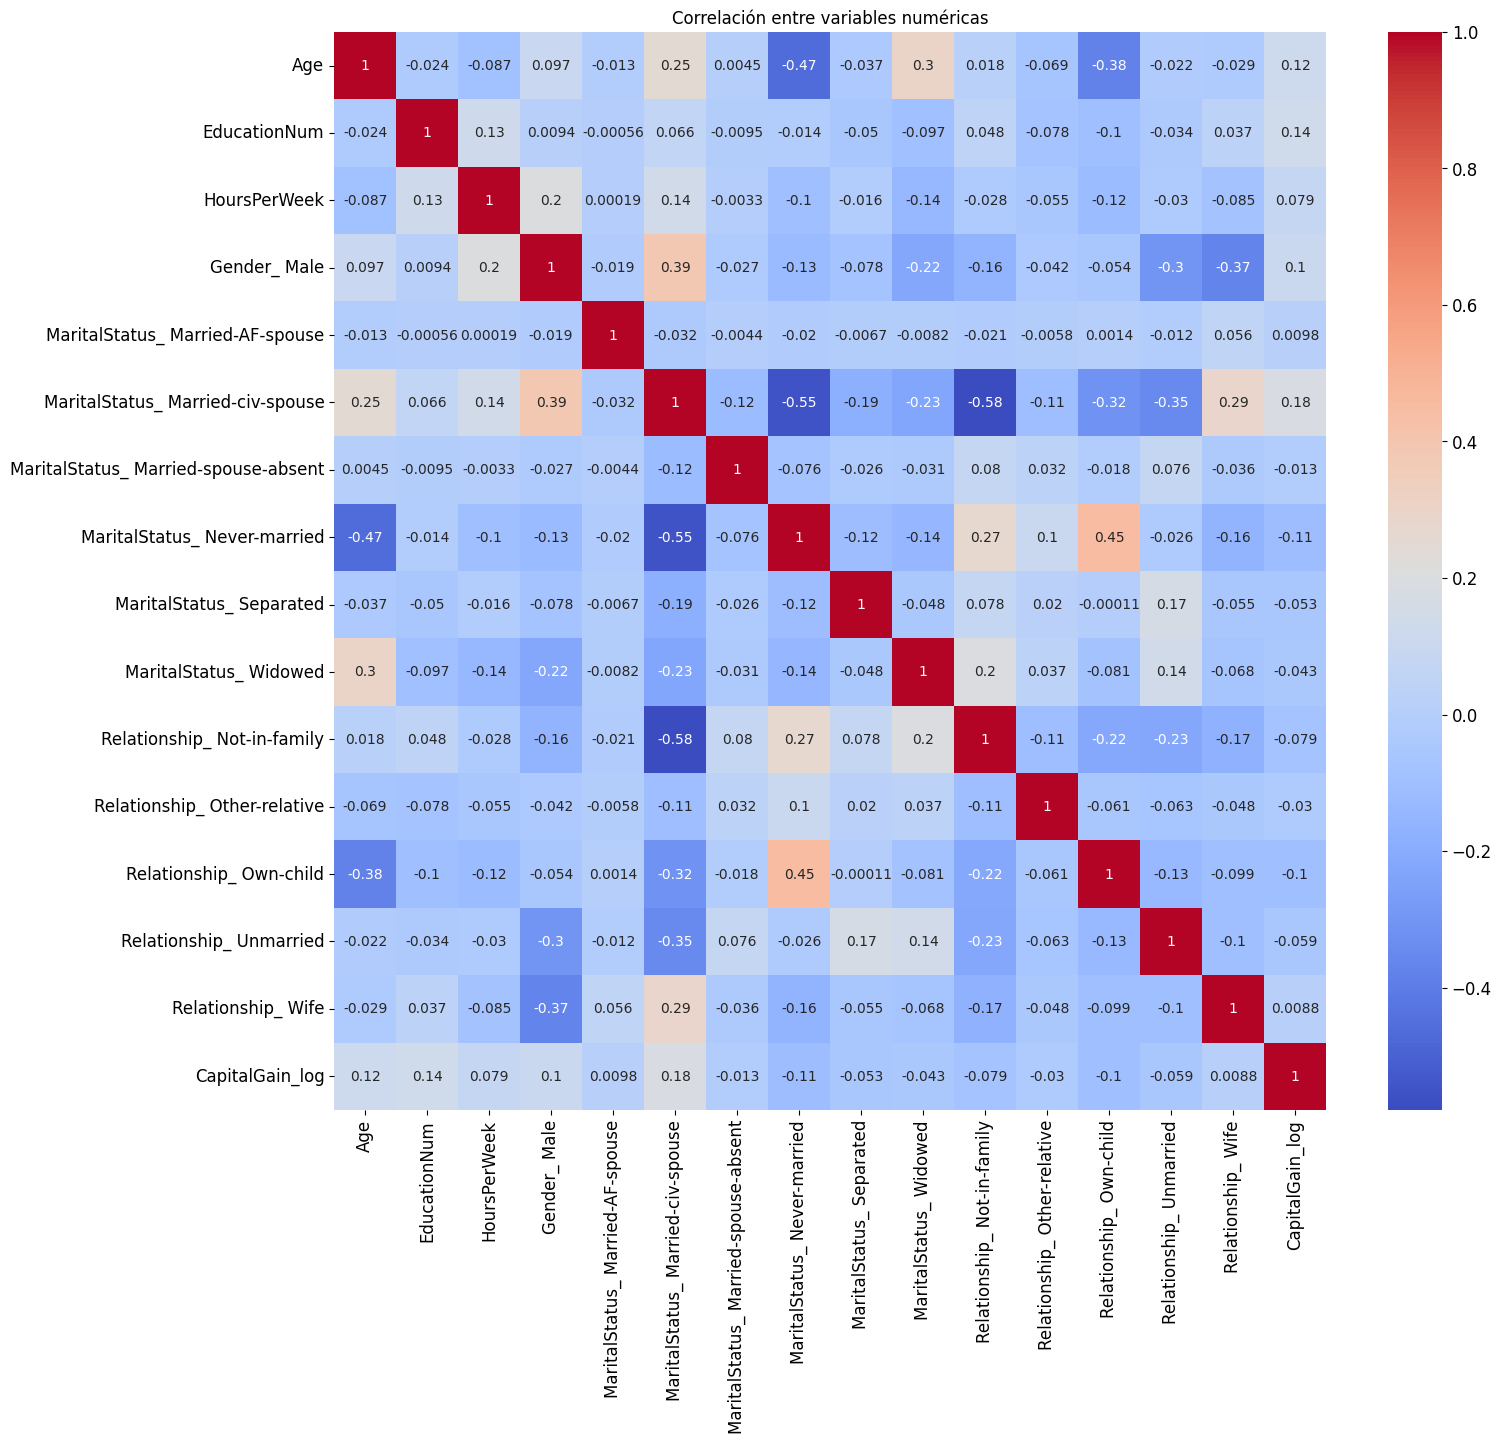

In [69]:
plt.figure(figsize=(16,14))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()

### 2. Hierarchical Clustering

Para clustering, necesitamos solo variables numéricas o variables codificadas numéricamente, y gracias a los métodos aplicados durante la limpieza podemos trabajar con todas las varibles de nuestro dataset.

Se aplicaron cuatro métodos de linkage: single, complete, average y Ward.

In [70]:
data_cluster = data.values.astype(float)
print(data_cluster)

[[-0.31538968  0.8520182  -0.0327975  ... -0.36862982 -0.27855483
   2.10876755]
 [ 0.41792416  0.8520182  -1.69479046 ... -0.36862982 -0.27855483
  -0.39183177]
 [ 0.55125395 -0.53764505  0.27497898 ... -0.36862982 -0.27855483
  -0.39183177]
 ...
 [ 1.41789758  1.54684982  1.1983084  ... -0.36862982 -0.27855483
   1.88307047]
 [-0.0487301  -0.19022924 -0.0327975  ... -0.36862982 -0.27855483
  -0.39183177]
 [ 0.55125395 -0.53764505 -0.0327975  ... -0.36862982  3.58995756
   2.73765645]]


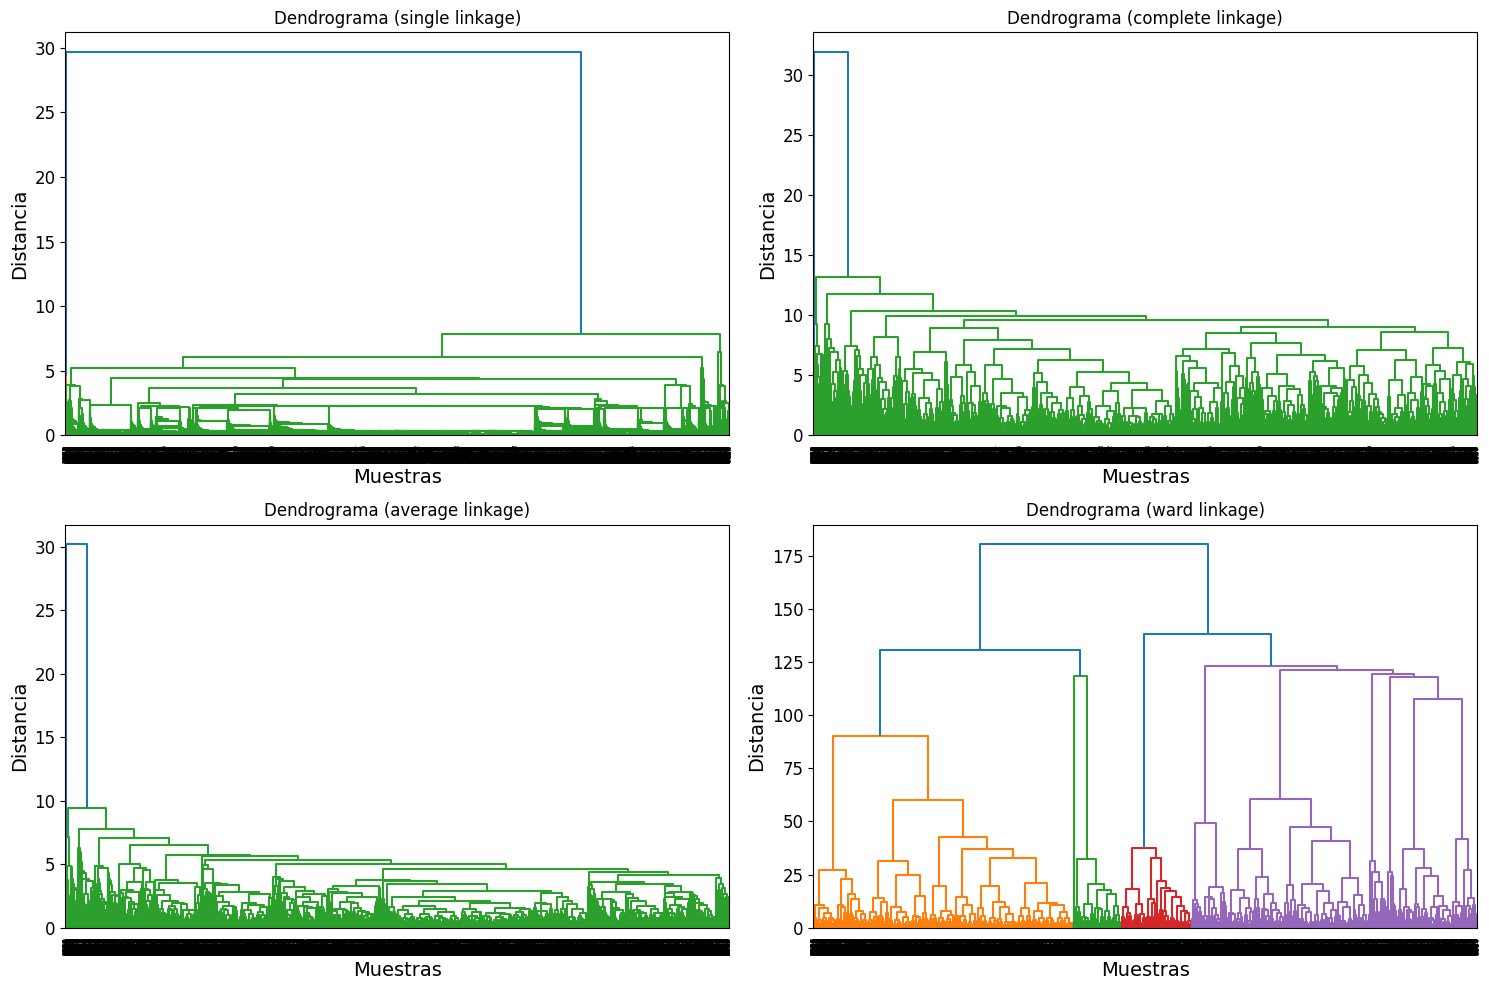

In [71]:
linkage_methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(15, 10))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    linkage_matrix = linkage(data_cluster, method=method)  
    dendrogram(linkage_matrix)
    plt.title(f"Dendrograma ({method} linkage)")
    plt.xlabel("Muestras")
    plt.ylabel("Distancia")

plt.tight_layout()
plt.show()

Single linkage: produce una estructura muy alargada, con fusiones tempranas y un gran salto final; los puntos se agrupan de manera secuencial sin formar grupos definidos.
 -> No resulta útil aquí para identificar clusters reales.

Complete linkage: las fusiones son más uniformes, los grupos se separan con saltos más claros (alrededor de distancia 12–13).
-> Mejora la separación entre clusters respecto a single.

Average linkage: comportamiento intermedio; las fusiones son más suaves, pero se observa un salto visible en distancia 10–11.
-> Sugiere 3–4 clusters potenciales.

Ward linkage: muestra una estructura muy clara y jerárquica; hay un salto grande en la distancia (~100–120), que marca la unión de tres grandes grupos.
-> Es el método más interpretable y consistente.

**Para elegir el valor de k vamos a fijarnos en el dendrograma de Ward, ya que nos da un valor más estable. Observando determinamos que el valor de k será entre 3 y 4.**

In [116]:
linkage_matrix = linkage(data_cluster, method='ward')
clusters = fcluster(linkage_matrix, t=4, criterion='maxclust')


df_clusters = pd.DataFrame(data_cluster, columns=data.columns)
df_clusters['cluster'] = clusters


summary = df_clusters.groupby('cluster').mean()
print(summary)


pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_cluster)



              Age  EducationNum  HoursPerWeek  Gender_ Male  \
cluster                                                       
1        0.352657      0.064367      0.232006      0.743598   
2       -0.108234      0.134795     -0.295249     -1.332575   
3       -1.092850     -0.284853     -0.355203     -0.145858   
4       -0.033517     -0.011129     -0.074146     -0.417856   

         MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
cluster                                                                        
1                               -0.033693                           1.057347   
2                                0.430576                           1.026048   
3                               -0.033693                          -0.884253   
4                               -0.033693                          -0.920625   

         MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
cluster                                                      

También se puede probar otra métrica, como la distancia Manhattan (L1), para explorar cómo cambia la estructura de los clusters. Esto es útil porque:

 - Manhattan mide la distancia sumando diferencias absolutas entre coordenadas, mientras que Euclídea usa la raíz cuadrada de la suma de cuadrados.

- Algunas distribuciones de datos o variables con escalas heterogéneas pueden producir agrupamientos más estables o menos sensibles a outliers con Manhattan.


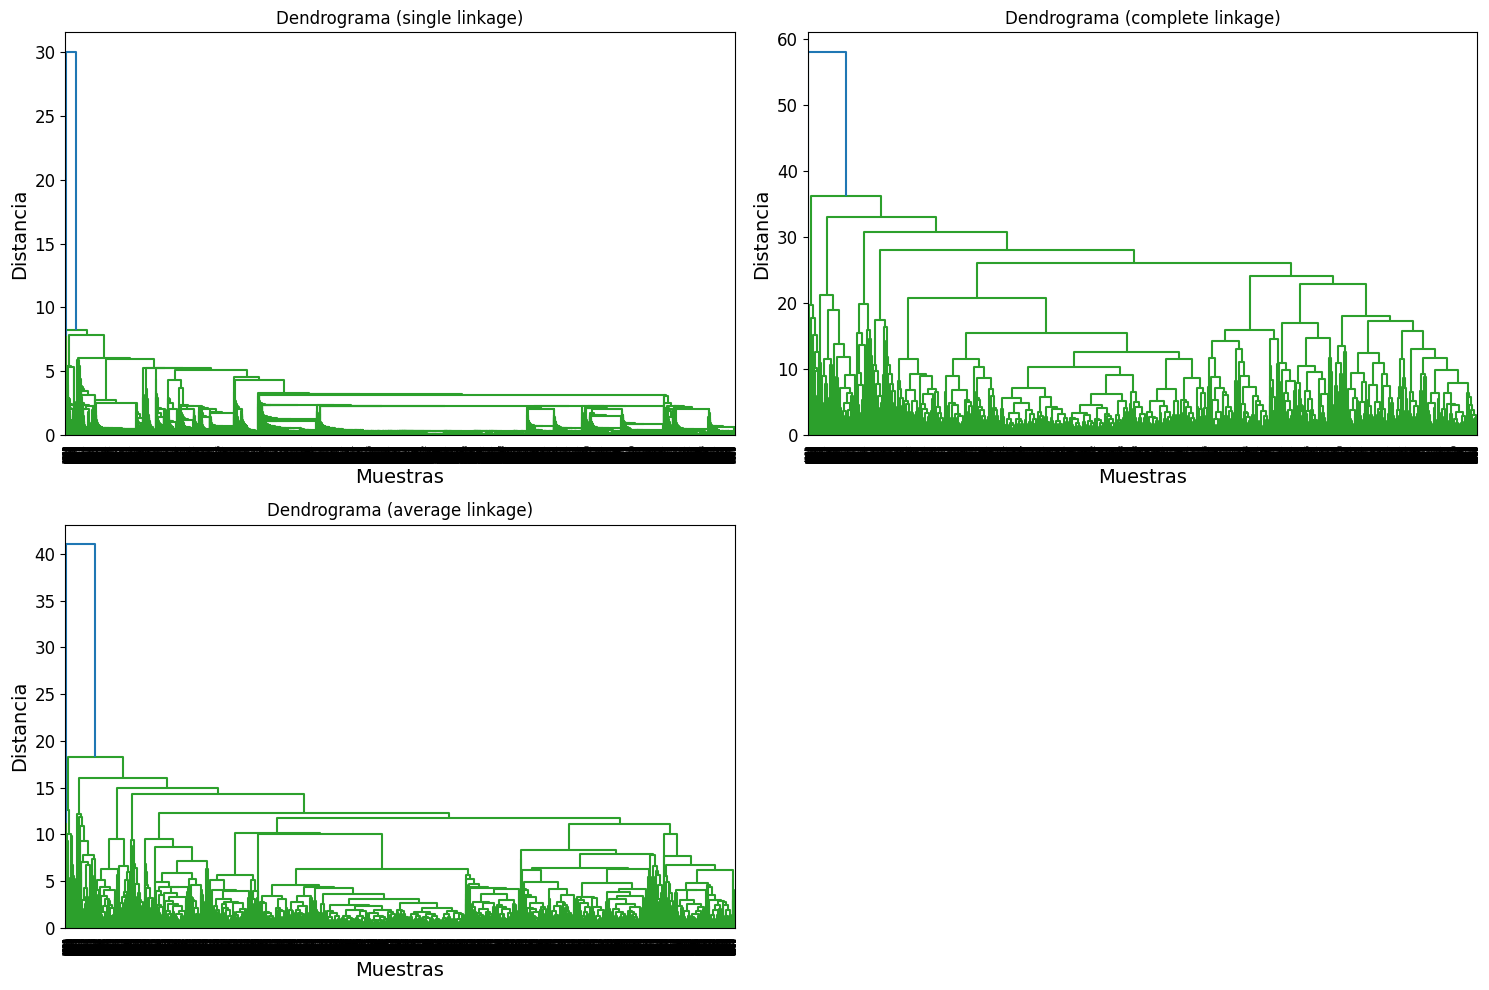

In [73]:
linkage_methods = ['single', 'complete', 'average']
data_cluster = data.values
plt.figure(figsize=(15, 10))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    linkage_matrix = linkage(data_cluster, method=method, metric='cityblock') # data_cluster = dataset numérico listo
    dendrogram(linkage_matrix)
    plt.title(f"Dendrograma ({method} linkage)")
    plt.xlabel("Muestras")
    plt.ylabel("Distancia")

plt.tight_layout()
plt.show()

Al usar la distancia Manhattan, el dendrograma tiende a agrupar todas las muestras en un solo cluster, mostrando poca diferenciación entre grupos. Esto ocurre porque, tras la normalización con StandardScaler, las diferencias absolutas entre variables son pequeñas, y Manhattan no distingue claramente los clusters. Por el contrario, la distancia euclídea es más adecuada en este caso, ya que refleja mejor la similitud real entre las observaciones en el espacio normalizado, permitiendo identificar agrupamientos más claros y significativos.

In [74]:
# Ejemplo con 'average' linkage
linkage_matrix = linkage(data_cluster, method='average', metric='cityblock')
clusters = fcluster(linkage_matrix, t=4, criterion='maxclust')
df_clusters = pd.DataFrame(data_cluster, columns=data.columns)
df_clusters['cluster'] = clusters

summary = df_clusters.groupby('cluster').mean()
print(summary)

              Age  EducationNum  HoursPerWeek  Gender_ Male  \
cluster                                                       
1       -0.398721     -0.016521      0.005675     -0.561658   
2        0.034601     -0.073426     -0.025368     -0.210589   
3       -0.417818     -0.461648     -0.338650     -0.278852   
4        0.011782      0.014436      0.010078      0.012236   

         MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
cluster                                                                        
1                               29.679538                          -0.945763   
2                               -0.033693                          -0.945763   
3                               -0.033693                          -0.611912   
4                               -0.033693                           0.034836   

         MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
cluster                                                      

### 3. Partitional Clustering

In [105]:
X = data.values

In [106]:
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

In [108]:
def plot_silhouette(model, X):
    mu = model.cluster_centers_
    K, D = mu.shape
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_scores = silhouette_score(X, model.labels_)
    cmap = plt.get_cmap("Pastel2")
    colors = [cmap(i) for i in range(K)]
    padding = len(X) // 30
    pos = padding
    for i in range(K):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / K)
        # color = colors[i]
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        pos += len(coeffs) + padding
    score = silhouette_scores
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title("$k={}, score={:0.2f}$".format(K, score), fontsize=16)

def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="o", s=30, linewidths=8, color=circle_color, zorder=10, alpha=0.9
    )
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="x", s=50, linewidths=50, color=cross_color, zorder=11, alpha=1
    )

def plot_decision_boundaries(model, X, resolution=1000):
    mu = model.cluster_centers_
    K, D = mu.shape
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # cmap = [mpl.cm.Spectral( (i / K)) for i in range(K)]
    cmap = "Pastel2"
    # cmap = mpl.cm.Spectral(K)
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap=cmap)
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(model.cluster_centers_)
    plt.title(f"K={K}")


Try K-means with different values of K

Para este paso se fija la semilla del generador de números aleatorios para garantizar reproducibilidad. KMeans comienza con centroides iniciales aleatorios, y fijar la semilla permite obtener siempre el mismo resultado al ejecutar el código varias veces.

Por KMeans realizará 10 inicializaciones distintas con centroides aleatorios y elegirá la que genere la menor inercia. Esto reduce el riesgo de que el algoritmo quede atrapado en un mínimo local y mejora la estabilidad del clustering.

In [98]:
Ks = range(1, 10)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X) for k in Ks]

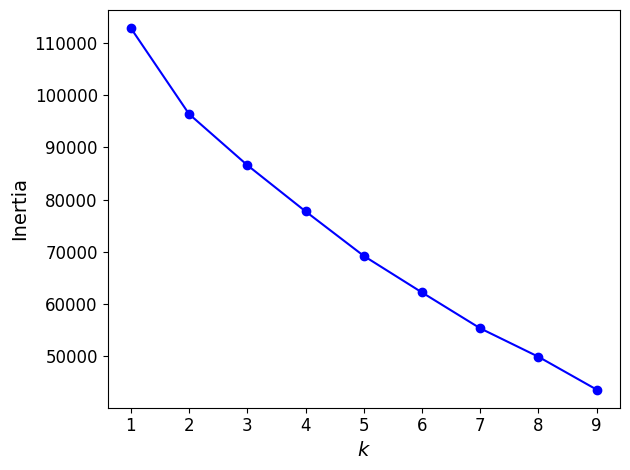

In [99]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure()
plt.plot(Ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
# plt.axis([1, 8.5, 0, 1300])
plt.tight_layout()
plt.show()

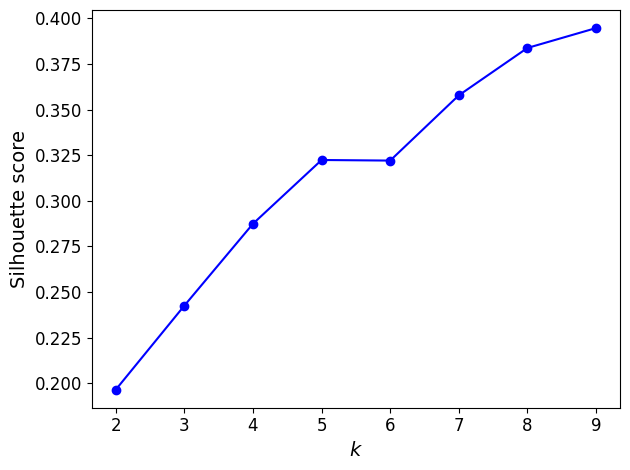

In [100]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure()
plt.plot(Ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.tight_layout()
plt.show()

El Silhouette aumenta mucho de k=2 a k=5,luego de k =5 a k=6 se aplana.

k=2, silhouette score=0.20
k=3, silhouette score=0.24
k=4, silhouette score=0.29
k=5, silhouette score=0.32
k=6, silhouette score=0.32
k=7, silhouette score=0.36
k=8, silhouette score=0.38


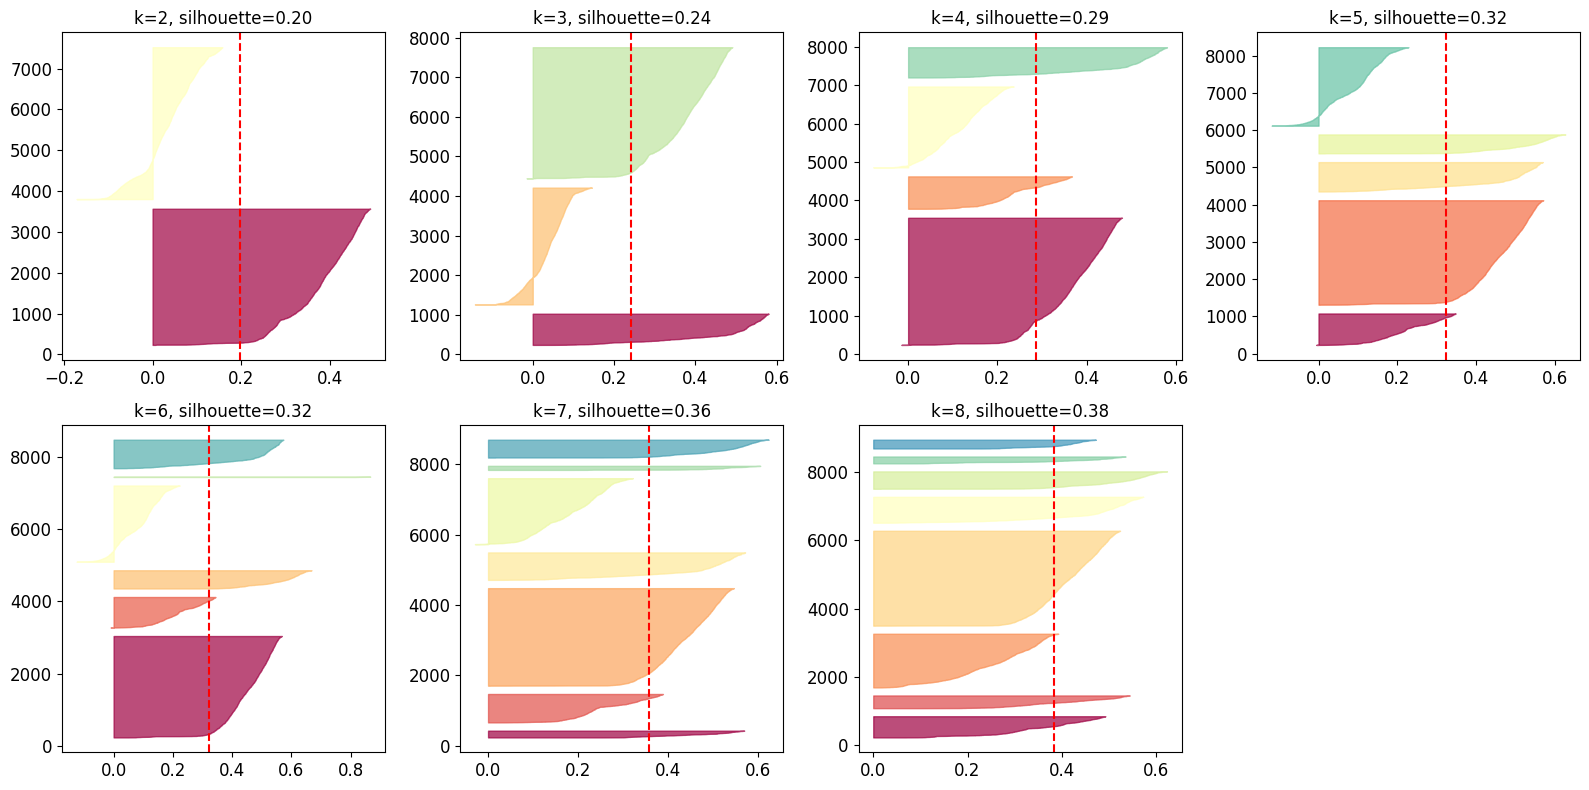

In [109]:
ks = [2, 3, 4, 5, 6, 7, 8]

n_cols = 4  # columnas por fila
n_rows = int(np.ceil(len(ks) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()  # para indexar fácilmente

for i, k in enumerate(ks):
    model = kmeans_per_k[k-1]  # recuerda ajustar índice de la lista
    X_labels = model.labels_
    score = silhouette_score(X, X_labels)
    print(f"k={k}, silhouette score={score:.2f}")
    
    plt.sca(axes[i])
    plot_silhouette(model, X)
    axes[i].set_title(f"k={k}, silhouette={score:.2f}")

# Ocultar subplots sobrantes si los hay
for j in range(len(ks), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

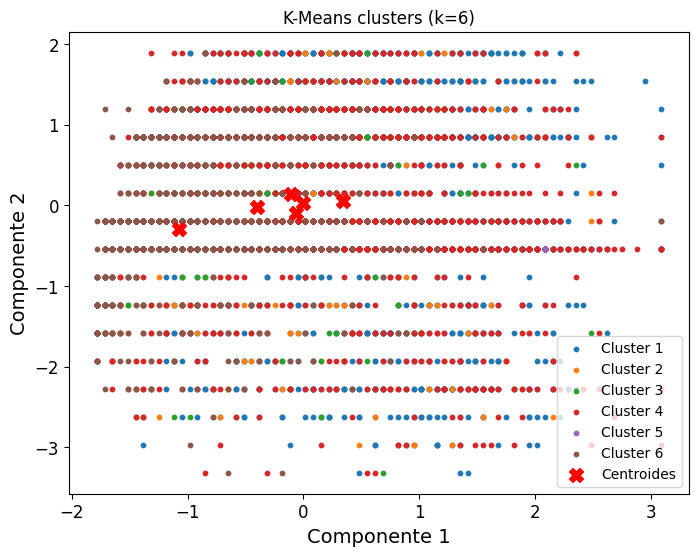

In [104]:
k = 6 
model = kmeans_per_k[k-1]
labels = model.labels_
centroids = model.cluster_centers_

plt.figure(figsize=(8,6))
for i in range(k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=10, label=f'Cluster {i+1}')
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='X', s=100, label='Centroides')
plt.title(f'K-Means clusters (k={k})')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.show()


Ahora para ver los datos y como se ehhan agrupado podemos crear una nueva columna que nos diga a que cluster pertenece y podemos desescalara los datos paar analizar visualemente como son las agrupaciones de los datos.

In [111]:
data_clustered = data.copy()  # ya limpio, sin duplicados ni NaN
data_cluster = data_clustered.values.astype(float)  # convertir a numpy

# K-Means sobre todo el dataset
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(data_cluster)

# Añadir columna Cluster
data_clustered['Cluster'] = labels

# Ver algunas filas de un cluster
print(data_clustered[data_clustered['Cluster'] == 0].head())

# Contar cuántos datos hay en cada cluster
print(data_clustered['Cluster'].value_counts())



        Age  EducationNum  HoursPerWeek  Gender_ Male  \
1  0.417924      0.852018     -1.694790      0.743598   
2  0.551254     -0.537645      0.274979      0.743598   
3 -0.915374      0.852018     -0.032797      0.743598   
6 -0.582049     -1.927308     -0.032797      0.743598   
7  0.817914      0.852018     -0.032797      0.743598   

   MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
1                         -0.033693                           1.057347   
2                         -0.033693                           1.057347   
3                         -0.033693                           1.057347   
6                         -0.033693                           1.057347   
7                         -0.033693                           1.057347   

   MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
1                             -0.129295                     -0.586134   
2                             -0.129295                     -0.586

In [ ]:
data_clustered = data_cleaned.copy()
data_clustered['Cluster'] = labels

data_original = pd.DataFrame(scaler.inverse_transform(data), columns=data_cleaned.columns)
data_original['Cluster'] = labels


In [113]:
print(data_original.head())


        Age  EducationNum  HoursPerWeek  Gender_ Male  \
0 -0.315390      0.852018     -0.032797      0.743598   
1  0.417924      0.852018     -1.694790      0.743598   
2  0.551254     -0.537645      0.274979      0.743598   
3 -0.915374      0.852018     -0.032797      0.743598   
4 -1.248698     -0.537645     -0.340574      0.743598   

   MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
0                         -0.033693                          -0.945763   
1                         -0.033693                           1.057347   
2                         -0.033693                           1.057347   
3                         -0.033693                           1.057347   
4                         -0.033693                          -0.945763   

   MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
0                             -0.129295                      1.706093   
1                             -0.129295                     -0.586

Ahora vamos a leer como se agruparon, imprimiendo los tres grupos diferentes.

In [114]:
# Suponiendo que k = número de clusters
k = data_original['Cluster'].nunique()

for i in range(k):
    print(f"\n--- Cluster {i} ---\n")
    print(data_original[data_original['Cluster'] == i].head())



--- Cluster 0 ---

        Age  EducationNum  HoursPerWeek  Gender_ Male  \
1  0.417924      0.852018     -1.694790      0.743598   
2  0.551254     -0.537645      0.274979      0.743598   
3 -0.915374      0.852018     -0.032797      0.743598   
6 -0.582049     -1.927308     -0.032797      0.743598   
7  0.817914      0.852018     -0.032797      0.743598   

   MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
1                         -0.033693                           1.057347   
2                         -0.033693                           1.057347   
3                         -0.033693                           1.057347   
6                         -0.033693                           1.057347   
7                         -0.033693                           1.057347   

   MaritalStatus_ Married-spouse-absent  MaritalStatus_ Never-married  \
1                             -0.129295                     -0.586134   
2                             -0.129295       

## 4. DBSCAN

Lo primero que realizaremos será una proyección 2D para hacer una primera visualización de nuestros datos.

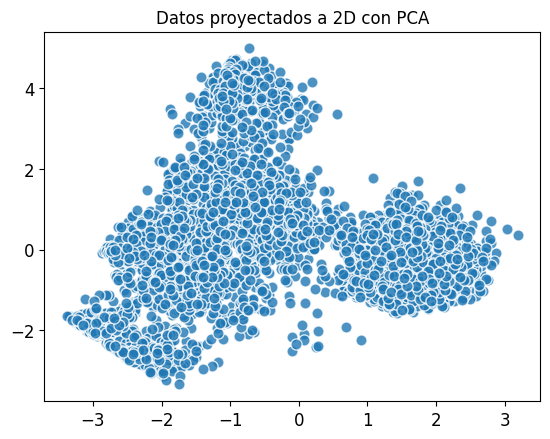

In [115]:
X_scaled = data[num_cols].values

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.8, s=64, edgecolors='white')
plt.title("Datos proyectados a 2D con PCA")
plt.show()


Observamos que de forma general, los puntos forman una especie de nube central con ciertas zonas más densas, lo que indica que probablemente haya subgrupos dentro del conjunto de datos, aunque no están completamente separados.

Además, se ven algunos puntos aislados alrededor de la nube principal; DBSCAN podría etiquetarlos como ruido (-1) según el valor de eps.

*Como la nube tiene formas irregulares; esto es un caso donde DBSCAN suele funcionar mejor que KMeans, porque KMeans asume clusters más esféricos.*

eps=0.3 → clusters: 163, puntos de ruido: 3935


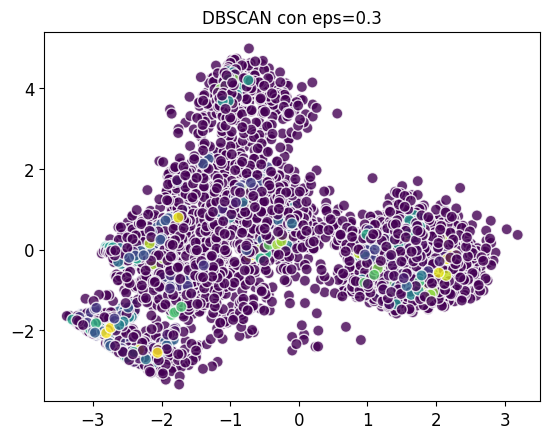

eps=0.5 → clusters: 55, puntos de ruido: 1631


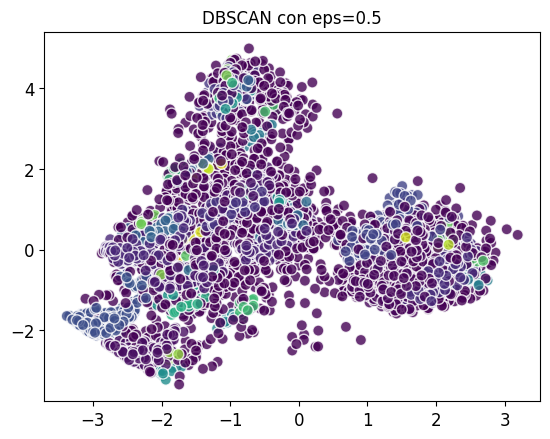

eps=0.7 → clusters: 48, puntos de ruido: 1001


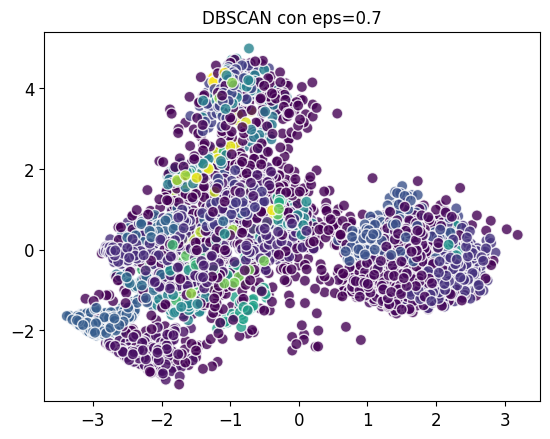

In [89]:
eps_values = [0.3, 0.5, 0.7]  # Ajustar según tus datos
min_samples = 5

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    
    print(f"eps={eps} → clusters: {n_clusters}, puntos de ruido: {n_noise}")
    
    # Graficar en 2D
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=64, alpha=0.8, edgecolors='white')
    plt.title(f"DBSCAN con eps={eps}")
    plt.show()


Para ajustar mejor los valores vamos a visulizar la grafica de la distancia al 5º vecino más cercano, se eligió analizar la distancia al 5º vecino porque el parámetro min_samples se estableció en 5. 

Esta gráfica permite identificar el valor de eps adecuado para DBSCAN, mostrando la distancia a partir de la cual los puntos empiezan a considerarse aislados y, por tanto, ruido. El “codo” de la curva indica un rango de densidad óptimo para formar clusters, facilitando la selección de un eps que agrupe correctamente los puntos densos del dataset.

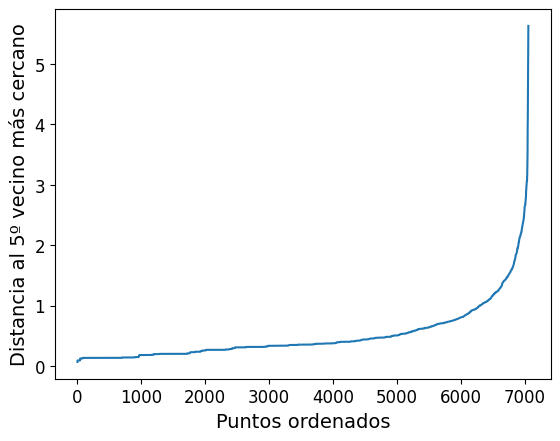

In [90]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4])  # 4 porque n_neighbors=5
plt.plot(distances)
plt.ylabel("Distancia al 5º vecino más cercano")
plt.xlabel("Puntos ordenados")
plt.show()


Basándonos en que el “codo” de la gráfica  está entre 8 000 y 10 000 en el eje X, podemos estimar un valor de eps usando la distancia al 5º vecino correspondiente en el eje Y en ese rango.

eps=0.95 → clusters: 48, puntos de ruido: 550


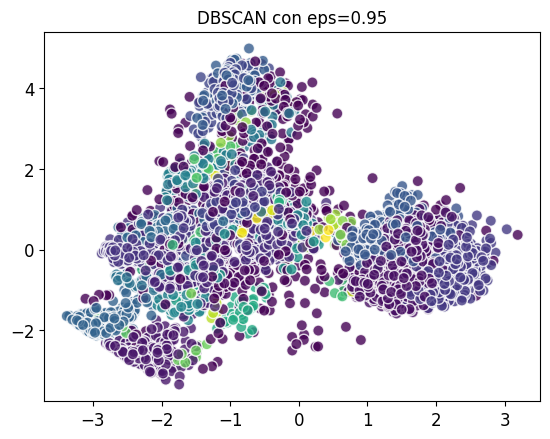

eps=1.2 → clusters: 51, puntos de ruido: 290


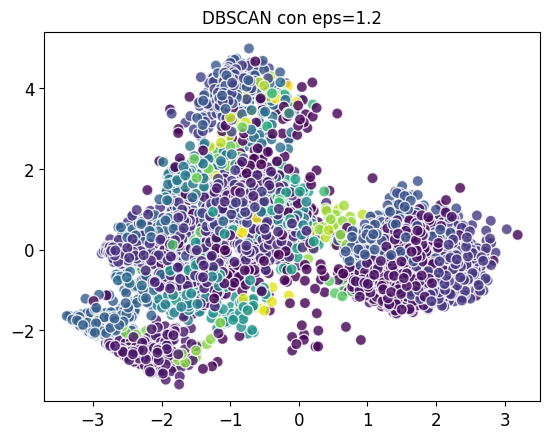

eps=1.5 → clusters: 53, puntos de ruido: 166


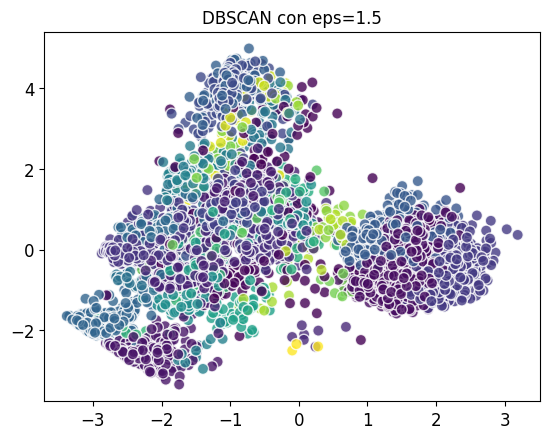

In [91]:
eps_values = [0.95, 1.2, 1.5] 
min_samples = 5

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    
    print(f"eps={eps} → clusters: {n_clusters}, puntos de ruido: {n_noise}")
    
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=64, alpha=0.8, edgecolors='white')
    plt.title(f"DBSCAN con eps={eps}")
    plt.show()



Al usar eps = 1.5, DBSCAN logra reducir significativamente el ruido (208 puntos de ruido frente a miles en pruebas anteriores) y agrupa mejor los puntos densos en clusters. Sin embargo, el número de clusters sigue siendo mucho mayor que los 3 clusters detectados por K-Means (52 clusters frente a 3).

Nos podemos plantear cambier el numero de min_samples pero:
- Si subes min_samples, el número de clusters podría disminuir ligeramente, pero el número de puntos de ruido aumentará.

- Si bajas min_samples, el número de clusters podría aumentar, pero habrá menos ruido.

Para visualizar ese fenomeno vamos a verlo graficamente:


--- min_samples = 3 ---
eps=0.95 → clusters: 79, puntos de ruido: 355


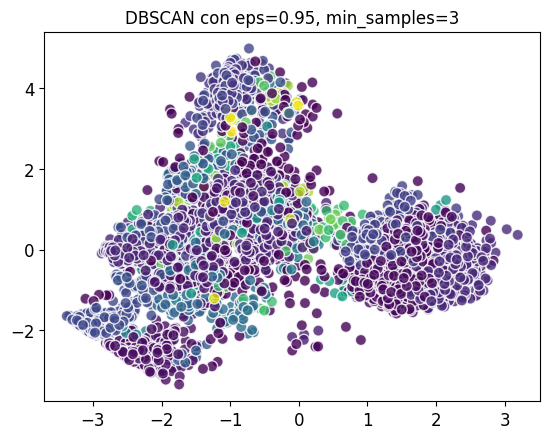

eps=1.2 → clusters: 65, puntos de ruido: 201


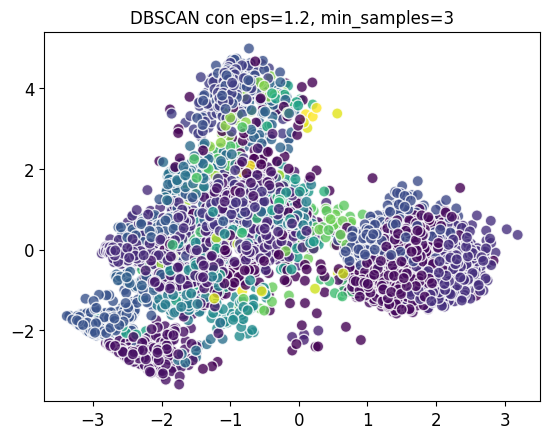

eps=1.5 → clusters: 66, puntos de ruido: 105


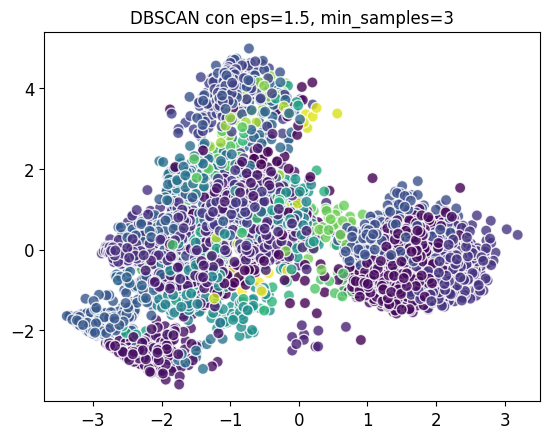


--- min_samples = 5 ---
eps=0.95 → clusters: 48, puntos de ruido: 550


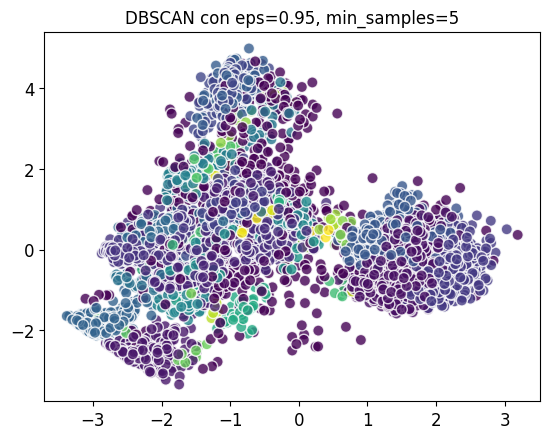

eps=1.2 → clusters: 51, puntos de ruido: 290


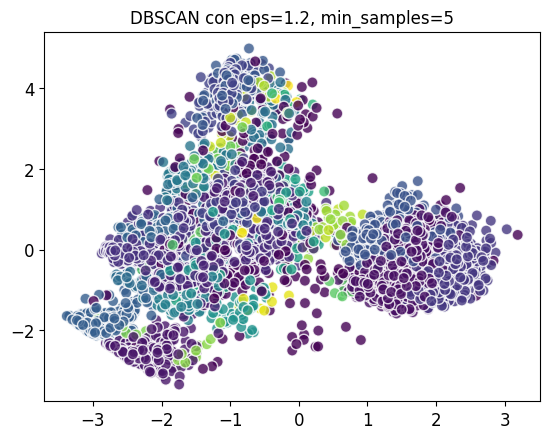

eps=1.5 → clusters: 53, puntos de ruido: 166


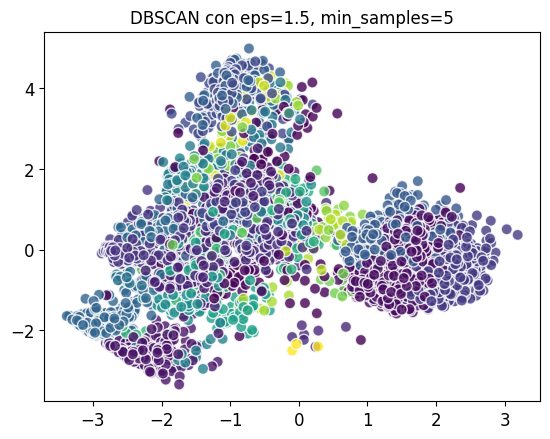


--- min_samples = 8 ---
eps=0.95 → clusters: 34, puntos de ruido: 735


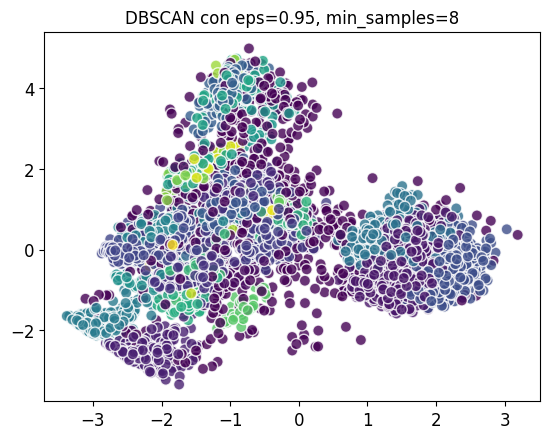

eps=1.2 → clusters: 37, puntos de ruido: 453


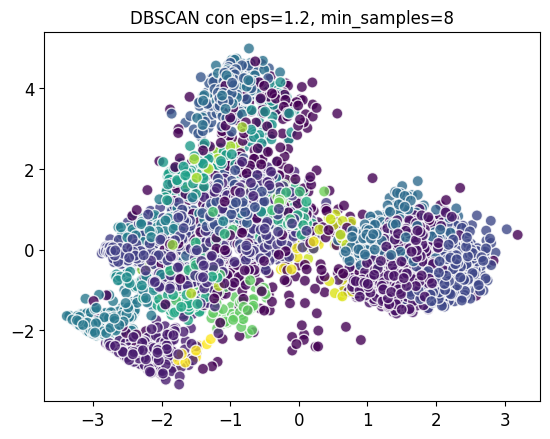

eps=1.5 → clusters: 42, puntos de ruido: 260


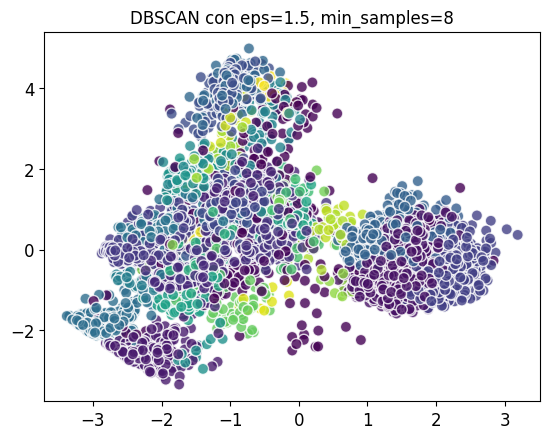

In [92]:
eps_values = [0.95, 1.2, 1.5]
min_samples_values = [3, 5, 8]
for min_samples in min_samples_values:
    print(f"\n--- min_samples = {min_samples} ---")
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        
        print(f"eps={eps} → clusters: {n_clusters}, puntos de ruido: {n_noise}")
        
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=64, alpha=0.8, edgecolors='white')
        plt.title(f"DBSCAN con eps={eps}, min_samples={min_samples}")
        plt.show()


En general, para reducir el ruido conviene aumentar eps, y para detectar clusters significativos conviene aumentar min_samples, pero no es posible que DBSCAN reproduzca exactamente el resultado de K-Means debido a su naturaleza basada en densidad.

In [93]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned)


eps_values = np.arange(0.3, 2.6, 0.1)
min_samples_values = [3, 5, 7, 10, 15, 20, 30, 50]


results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        
        # Calcular métricas solo si hay más de 1 cluster
        if n_clusters > 1:
            sil = silhouette_score(X_scaled, labels)
            db = davies_bouldin_score(X_scaled, labels)
        else:
            sil = np.nan
            db = np.nan
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'clusters': n_clusters,
            'noise_points': n_noise,
            'silhouette': sil,
            'davies_bouldin': db
        })

# Convertir a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


KeyboardInterrupt: 

Como la visalización a través de los gráficos es más costoso vamos a crear un mapa de calor con los diferentes silhouette score dado los diferentes palores para min_samples y eps.

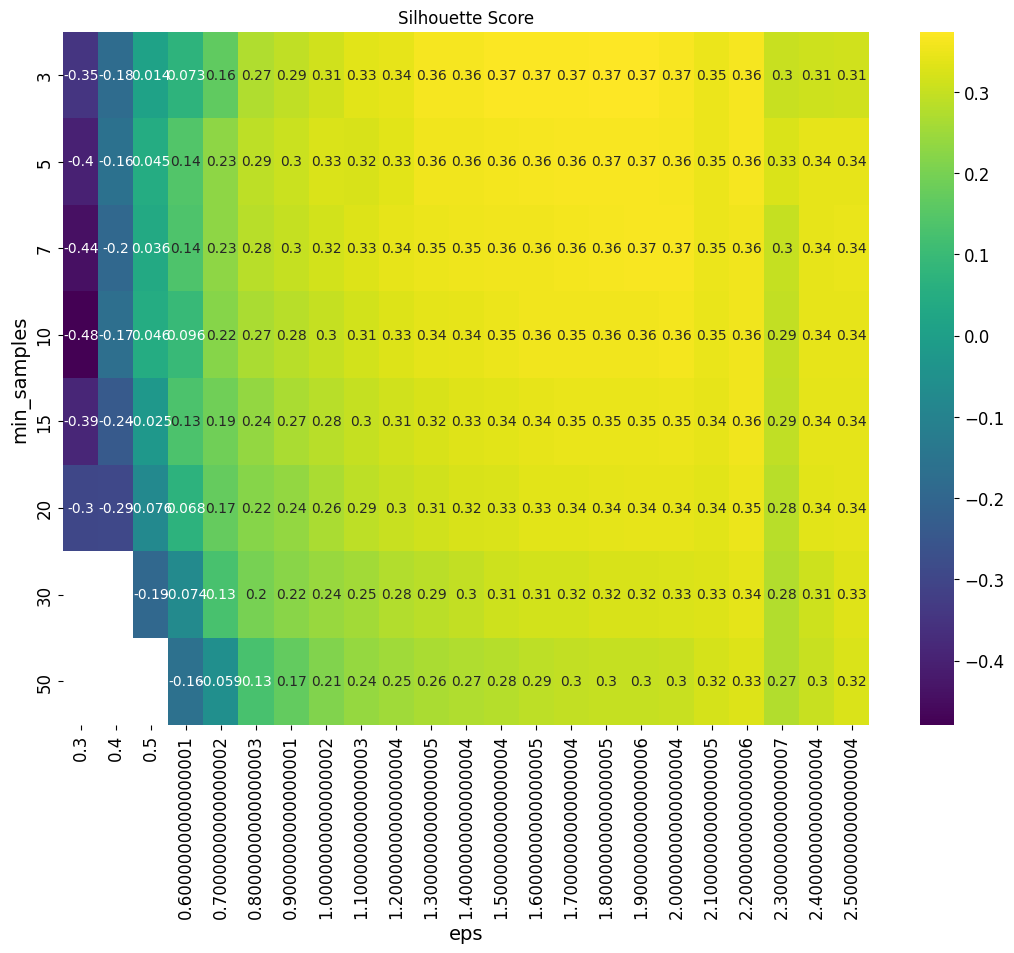

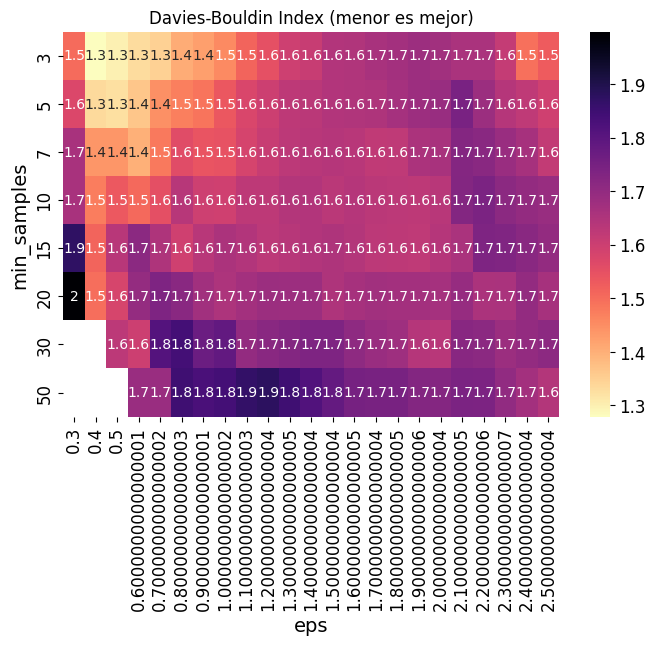

In [ ]:
pivot_sil = results_df.pivot(index='min_samples', columns='eps', values='silhouette')
plt.figure(figsize=(13,9))
sns.heatmap(pivot_sil, annot=True, cmap='viridis')
plt.title("Silhouette Score")
plt.show()

pivot_db = results_df.pivot(index='min_samples', columns='eps', values='davies_bouldin')
plt.figure(figsize=(8,5))
sns.heatmap(pivot_db, annot=True, cmap='magma_r')
plt.title("Davies-Bouldin Index (menor es mejor)")
plt.show()


Y por último que datos pertenecen a cada clustering para asi poder saber en que se vaso para agruparlos.

In [ ]:
# DataFrame con los datos originales (sin escalar) + cluster asignado
df_clusters = data_cleaned.copy()  # tus datos numéricos originales
df_clusters['Cluster'] = labels_best  # clusters asignados por DBSCAN

print("Cantidad de puntos por cluster (DBSCAN):")
print(df_clusters['Cluster'].value_counts())

print("\nPromedio de cada variable por cluster:")
print(df_clusters.groupby('Cluster').mean())

clusters_dict = {cluster: df_clusters[df_clusters['Cluster'] == cluster].index.tolist()
                 for cluster in df_clusters['Cluster'].unique()}

# Por ejemplo, ver los índices del cluster 0
print("Índices del cluster 0:")
print(clusters_dict.get(0, "No existe cluster 0"))

# Índices del ruido
print("Índices de puntos de ruido (-1):")
print(clusters_dict.get(-1, []))

summary = df_clusters.groupby('Cluster').mean()
for cluster in summary.index:
    print(f"\nCluster {cluster}:")
    print(summary.loc[cluster])


Cantidad de puntos por cluster (DBSCAN):
Cluster
 0     2165
-1     1001
 6      517
 3      408
 11     405
 1      332
 5      306
 4      261
 13     252
 7      244
 2      228
 8      143
 14     104
 22      76
 19      62
 20      61
 21      42
 15      41
 26      34
 16      28
 18      28
 12      27
 9       27
 23      24
 35      23
 33      19
 37      19
 28      17
 36      17
 24      15
 45      15
 40      11
 39       8
 32       7
 34       7
 41       7
 38       7
 27       7
 30       7
 10       6
 42       6
 29       6
 31       6
 25       5
 17       5
 44       5
 47       5
 46       5
 43       4
Name: count, dtype: int64

Promedio de cada variable por cluster:
              Age  EducationNum  HoursPerWeek  Gender_ Male  \
Cluster                                                       
-1       0.233180     -0.377993     -0.015026     -0.282873   
 0       0.330875      0.001050      0.197331      0.743598   
 1      -1.279219     -0.347194     -0.310909

In [ ]:
for cluster in df_clusters['Cluster'].unique():
    print(f"\n===== Cluster {cluster} =====")
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster]
    print(cluster_data.head(10))  # primeras 10 filas de cada cluster



===== Cluster 37 =====
           Age  EducationNum  HoursPerWeek  Gender_ Male  \
0    -0.315390      0.852018     -0.032797      0.743598   
633  -0.448719      0.157187     -0.032797      0.743598   
1439 -0.915374      0.852018      0.274979      0.743598   
1827 -0.515384      1.199434      0.274979      0.743598   
1916 -0.582049      1.199434     -0.032797      0.743598   
2789  0.017935      1.546850     -0.032797      0.743598   
2976  0.484589      1.546850     -0.032797      0.743598   
3874 -0.448719      1.894266      0.274979      0.743598   
3935 -0.448719      0.157187     -0.032797      0.743598   
4666 -1.048704      1.546850     -0.032797      0.743598   

      MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
0                            -0.033693                          -0.945763   
633                          -0.033693                          -0.945763   
1439                         -0.033693                          -0.945763   
1827   

## 5. Gaussian Mixture Models

In [ ]:
def ensure_2d_array(arr):
    arr = np.asarray(arr)
    if arr.ndim == 0:
        arr = np.array([arr])
    if arr.ndim == 2:
        return arr
    elif arr.ndim == 1:
        return np.diag(arr)
    else:
        raise ValueError("Input must be 1D or 2D array.")


color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_ggm(X, Y_, means, covariances, title):
    plt.figure(figsize=(8, 6))
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(ensure_2d_array(covar))
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)
        angle = np.arctan2(u[1], u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=angle, color=color, alpha=0.5)
        plt.gca().add_artist(ell)
    plt.scatter(means[:, 0], means[:, 1], marker='x', c='red', s=100, label='Means')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
def gmm_bic_score(estimator, X):
# Negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

X = data.select_dtypes(include=np.number).values

gm = GaussianMixture(n_components=2, random_state=0, n_init=2, max_iter=200)
gm.fit(X)

print("Component weights:", gm.weights_)
print("Means:", gm.means_)
print("Covariances:", gm.covariances_)

labels = gm.predict(X)
probs = gm.predict_proba(X)

Component weights: [0.4724309 0.5275691]
Means: [[ 0.26539296  0.06910786  0.14616164  0.40900161  0.03762564  1.05253901
  -0.12929465 -0.58613446 -0.198714   -0.2432083  -0.61651121 -0.11296059
  -0.33253268 -0.36862982  0.31106542  0.19481695]
 [-0.23765576 -0.06188514 -0.13088575 -0.36625534 -0.03369325 -0.94253426
   0.11578159  0.52487538  0.17794567  0.2177897   0.55207734  0.10115466
   0.29777846  0.33010295 -0.27855483 -0.17445591]]
Covariances: [[[ 8.24700291e-01 -9.53683651e-02 -2.31568326e-01  1.31545786e-01
   -4.73638549e-02  3.19302279e-03 -1.57724845e-30  8.12519632e-29
    2.16308358e-29 -1.66093918e-29  7.41628657e-29 -4.79387250e-02
   -2.35245263e-02  2.62054244e-30 -2.18562345e-01  6.08782438e-02]
  [-9.53683651e-02  1.13400109e+00  7.55681382e-02 -1.53212791e-02
   -6.10697860e-03  4.11700481e-04 -2.71710867e-31  1.34662556e-29
    4.43068591e-30 -3.24916967e-30  1.39585541e-29 -2.88193386e-02
   -4.92755894e-03  5.30877591e-31  3.86262385e-02  1.65337427e-01]
  

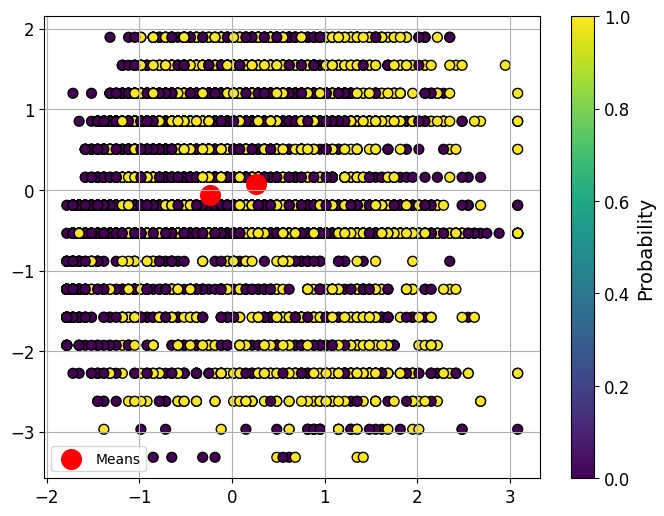

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=probs[:,0], cmap='viridis', s=50, edgecolors='k')
plt.scatter(gm.means_[:,0], gm.means_[:,1], c='red', s=200, marker='o', label='Means')
plt.colorbar(label='Probability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data['Cluster'] = labels
print("\nConteo de puntos por cluster:")
print(data['Cluster'].value_counts())


Conteo de puntos por cluster:
Cluster
1    3722
0    3333
Name: count, dtype: int64



Mejor configuración según BIC:
{'covariance_type': 'diag', 'n_components': 6}
BIC del mejor modelo: -481538.1321822527


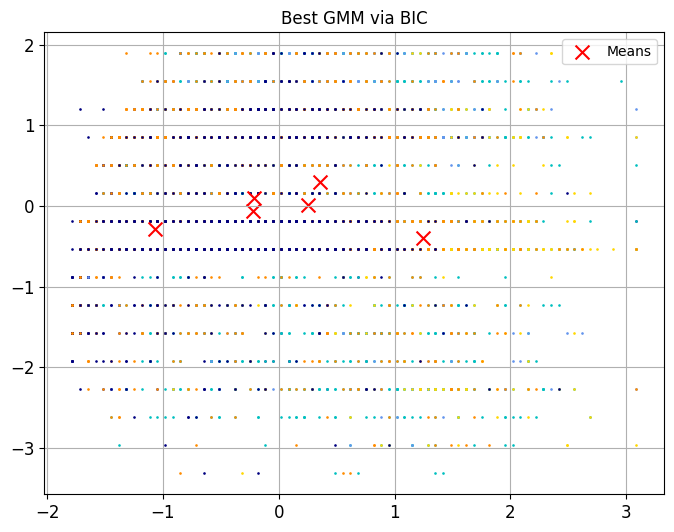

In [ ]:
param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"]
}

grid_search = GridSearchCV(GaussianMixture(random_state=0, n_init=2),
                           param_grid=param_grid,
                           scoring=gmm_bic_score)
grid_search.fit(X)

best_gmm = grid_search.best_estimator_
print("\nMejor configuración según BIC:")
print(grid_search.best_params_)
print("BIC del mejor modelo:", best_gmm.bic(X))

# Visualizar clusters del mejor modelo
best_labels = best_gmm.predict(X)
plot_ggm(X, best_labels, best_gmm.means_, best_gmm.covariances_, "Best GMM via BIC")

In [ ]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

Number of components Type of covariance     BIC score
17                     6               diag -99436.963294
22                     5               full -98207.299758
16                     5               diag -85192.781148
19                     2               full -30077.370902
11                     6               tied -17621.867577

In [ ]:
print("Mejor configuración GMM según BIC:")
print(grid_search.best_params_)
best_gmm = grid_search.best_estimator_

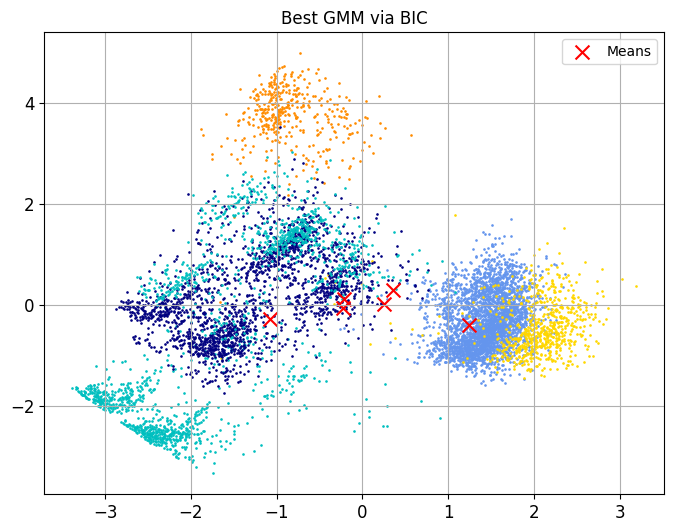

In [ ]:
from sklearn.decomposition import PCA
X_2d = PCA(n_components=2).fit_transform(X)
plot_ggm(X_2d, best_gmm.predict(X), best_gmm.means_[:, :2], best_gmm.covariances_, "Best GMM via BIC")


In [ ]:
labels = best_gmm.predict(X)
data['Cluster'] = labels

print(data['Cluster'].value_counts())

for cluster_num in data['Cluster'].unique():
    print(f"\nCluster {cluster_num}:")
    print(data[data['Cluster'] == cluster_num])

Cluster
1    2645
4    1834
0     787
5     724
2     671
3     394
Name: count, dtype: int64

Cluster 4:
           Age  EducationNum  HoursPerWeek  Gender_ Male  \
0    -0.315390      0.852018     -0.032797      0.743598   
9    -1.382028      0.504602      0.705866      0.743598   
16    0.417924      0.852018      0.890532      0.743598   
17    0.217929     -0.537645      1.198308      0.743598   
18   -0.782044     -2.274724     -0.032797      0.743598   
...        ...           ...           ...           ...   
9847  2.551201     -0.537645     -2.310343      0.743598   
9854 -0.915374      0.852018      3.598965     -1.344812   
9857 -0.182060     -0.537645     -0.525240     -1.344812   
9861  1.417898      1.546850      1.198308      0.743598   
9862 -0.048730     -0.190229     -0.032797     -1.344812   

      MaritalStatus_ Married-AF-spouse  MaritalStatus_ Married-civ-spouse  \
0                            -0.033693                          -0.945763   
9                  

In [ ]:
cluster_summary = data.groupby('Cluster').agg(['mean', 'std'])
print(cluster_summary)


              Age           EducationNum           HoursPerWeek            \
             mean       std         mean       std         mean       std   
Cluster                                                                     
0       -1.072252  0.661711    -0.286905  0.800795    -0.342608  0.998131   
1        0.250140  0.913778     0.012572  1.076011     0.123872  1.105426   
2        0.353842  0.873099     0.300088  0.995976     0.233514  0.904423   
3        1.243960  0.798534    -0.400090  0.996950    -0.580077  0.945499   
4       -0.209867  0.902894     0.103767  0.960637     0.025167  0.877195   
5       -0.221562  0.712601    -0.057309  0.857929    -0.044615  0.768056   

        Gender_ Male           MaritalStatus_ Married-AF-spouse            \
                mean       std                             mean       std   
Cluster                                                                     
0          -0.148023  1.033654                        -0.033693  0.000000  